In [1]:
import main_gaussian 
import frank_wolfe
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sklearn import preprocessing
from importlib import reload
from collections import defaultdict
reload(frank_wolfe)
reload(main_gaussian)

from tqdm.notebook import tqdm
from sklearn.cluster import KMeans


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [2]:
import torch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
def evaluate_subset(train_subset, train_x, train_y, test_x, test_y, use_ridge=False):
    if isinstance(train_x, torch.Tensor):
        train_x = train_x.numpy()
        train_y = train_y.numpy()
        test_x = test_x.numpy()
        test_y = test_y.numpy()
    if use_ridge:
        reg = Ridge(fit_intercept=False)
    else:
        reg = LinearRegression(fit_intercept=False)
    reg.fit(train_x[train_subset], train_y[train_subset])
    pred = reg.predict(test_x)
    error = mean_squared_error(test_y, pred)
    return error

In [3]:
def gen_data(
    num_seller,
    num_buyer,
    dim,
    multi_dist=False,
    cluster_buyer=False,
    ):

    # True coefficients
    beta_true = np.random.exponential(scale=1, size=dim)
    beta_true *= np.sign(np.random.random(size=dim))

    if multi_dist:
        # Distribution 1
        x_sell_1 = np.random.normal(size=(num_seller, dim))
        x_sell_1 /= np.linalg.norm(x_sell_1, axis=1, keepdims=True) 
        y_sell_1 = x_sell_1 @ beta_true + 10 * np.random.randn(num_seller)
        
        # Distribution 2
        x_sell_2 = np.random.exponential(size=[num_seller, dim])
        x_sell_2 /= np.linalg.norm(x_sell_2, axis=1, keepdims=True)  
        y_sell_2 = x_sell_2 @ beta_true + 10 * np.random.randn(num_seller)
        
        x_sell = np.concatenate([x_sell_1, x_sell_2])
        y_sell = np.concatenate([y_sell_1, y_sell_2])
        
        # Distribution 3
        x_sell_3 = np.random.beta(0.5, 0.5, size=[num_seller, dim])
        x_sell_3 /= np.linalg.norm(x_sell_3, axis=1, keepdims=True)  
        y_sell_3 = x_sell_3 @ beta_true + 10 * np.random.randn(num_seller)
        
        x_sell = np.concatenate([x_sell_1, x_sell_2, x_sell_3])
        y_sell = np.concatenate([y_sell_1, y_sell_2, y_sell_3])
    else:
        x_sell = np.random.normal(size=(num_seller, dim))
        x_sell /= np.linalg.norm(x_sell, axis=1, keepdims=True) 
        y_sell = x_sell @ beta_true + 10 * np.random.randn(num_seller)
    
    x_buy = np.random.normal(size=[num_buyer, dim])
    x_buy /= np.linalg.norm(x_buy, axis=1, keepdims=True)  
    y_buy = x_buy @ beta_true

    if cluster_buyer:
        KM = KMeans(n_clusters=10, init="k-means++", n_init='auto')
        KM.fit(x_buy)
        clusters = KM.labels_
        buy_index = clusters == 0
        sell_index = KM.predict(x_sell) == 0
        print('num in buyer cluster', buy_index.nonzero()[0].shape)
        print('num in seller cluster', sell_index.nonzero()[0].shape)
        x_buy = x_buy[buy_index]
        y_buy = y_buy[buy_index]
        return x_sell, y_sell, x_buy, y_buy, sell_index, buy_index, beta_true
    else:
        return x_sell, y_sell, x_buy, y_buy, beta_true

In [4]:
x_sell, y_sell, x_buy, y_buy, *_ = gen_data(
    num_seller = 5000,
    num_buyer = 100,
    dim = 1000,
    multi_dist=False,
    cluster_buyer=False,
)

In [6]:
# def overlap(seller_selected, sell_index=sell_index):
#     union = set(seller_selected) & set(sell_index.nonzero()[0])
#     percent = len(union) / len(np.unique(seller_selected))
#     return round(percent, 2), union

In [7]:
def exp(
    x_sell, y_sell, x_buy, y_buy,
    num_iters,
    num_b,
    baselines=True,
    num_oob=10,
    rang = [round(x) for x in np.arange(1, 100, 5)],
):
    # num_iters = min(500, x_buy.shape[0])
    design_res = main_gaussian.design_selection((x_sell, y_sell), (x_buy[:num_b], y_buy[:num_b]), num_iters=num_iters, alpha=0.1, scale_cov=True)
    
    design = {k: evaluate_subset(np.random.choice(np.arange(len(x_sell)), p=design_res['weights'], size=k), x_sell, y_sell, x_buy, y_buy) for k in rang}
    
    # s = 100
    # d_sel = np.random.choice(np.arange(len(x_sell)), p=design_res['weights'], size=s)
    # d_uni = len(np.unique(d_sel))
    # print(d_uni / s, d_uni)
    # overlap(d_sel)
    
    if baselines:
        # baselines
        seller_random = {k: evaluate_subset(np.random.permutation(np.arange(len(x_sell)))[:k], x_sell, y_sell, x_buy, y_buy) for k in rang}
        buyer_random = {k: evaluate_subset(np.arange(x_buy.shape[0])[:k], x_buy, y_buy, x_buy, y_buy) for k in rang}
    
        one_step_values = frank_wolfe.one_step(x_sell, x_buy)
        one_step = {k: evaluate_subset(one_step_values.argsort()[-k:], x_sell, y_sell, x_buy, y_buy) for k in rang}
    
        oob_values = main_gaussian.get_baseline_values(
            x_sell, y_sell, np.ones_like(x_buy), np.ones_like(y_buy), np.ones_like(x_buy), np.ones_like(y_buy), 
            baseline_kwargs={'DataOob': 
                             {'num_models': num_oob}
                            },
        )['DataOob']
        
        oob = {k: evaluate_subset(oob_values.argsort()[-k:], x_sell, y_sell, x_buy, y_buy) for k in rang}


        return dict(design=design, one_step=one_step, buyer_random=buyer_random, seller_random=seller_random, oob=oob)
    else:
        return dict(design=design)

In [8]:
res = exp(
    x_sell, y_sell, x_buy, y_buy,
    num_iters = 10,
    num_b = 10,
    baselines=True,
    num_oob=10,
    rang = [round(x) for x in np.arange(1, 30, 5)],
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.32it/s]


In [11]:
# num_seller = 5000
num_buyer = 1000
num_iters = 100  # number of optimization steps in design
num_b     = 100  # number of buyers to use in design
num_oob   = 100   # number of models to use in oob


seller_res = defaultdict(dict)
sellers = [1000, 5000, 10000, 25000]
dims = [100, 500, 1000, 5000]

for num_seller in sellers:
    print(f'{num_seller = }'.center(40, '*'))
    dim_res = defaultdict(dict)
    for dim in dims:
        x_sell, y_sell, x_buy, y_buy, *_ = gen_data(
            num_seller = num_seller,
            num_buyer = num_buyer,
            dim = dim,
            multi_dist=False,
            cluster_buyer=False,
        )
        res = exp(
            x_sell, y_sell, x_buy, y_buy,
            num_iters = num_iters,
            num_b = num_b,
            baselines=True,
            num_oob=num_oob,
            rang = [round(x) for x in np.arange(1, 250, 5)],
        )
        dim_res[dim] = res

    seller_res[num_seller] = dim_res

***********num_seller = 1000************


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:33<00:00,  1.07it/s]


***********num_seller = 5000************


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [15:21<00:00,  9.21s/it]


***********num_seller = 10000***********


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [21:51<00:00, 13.12s/it]


***********num_seller = 25000***********


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [33:04<00:00, 19.85s/it]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


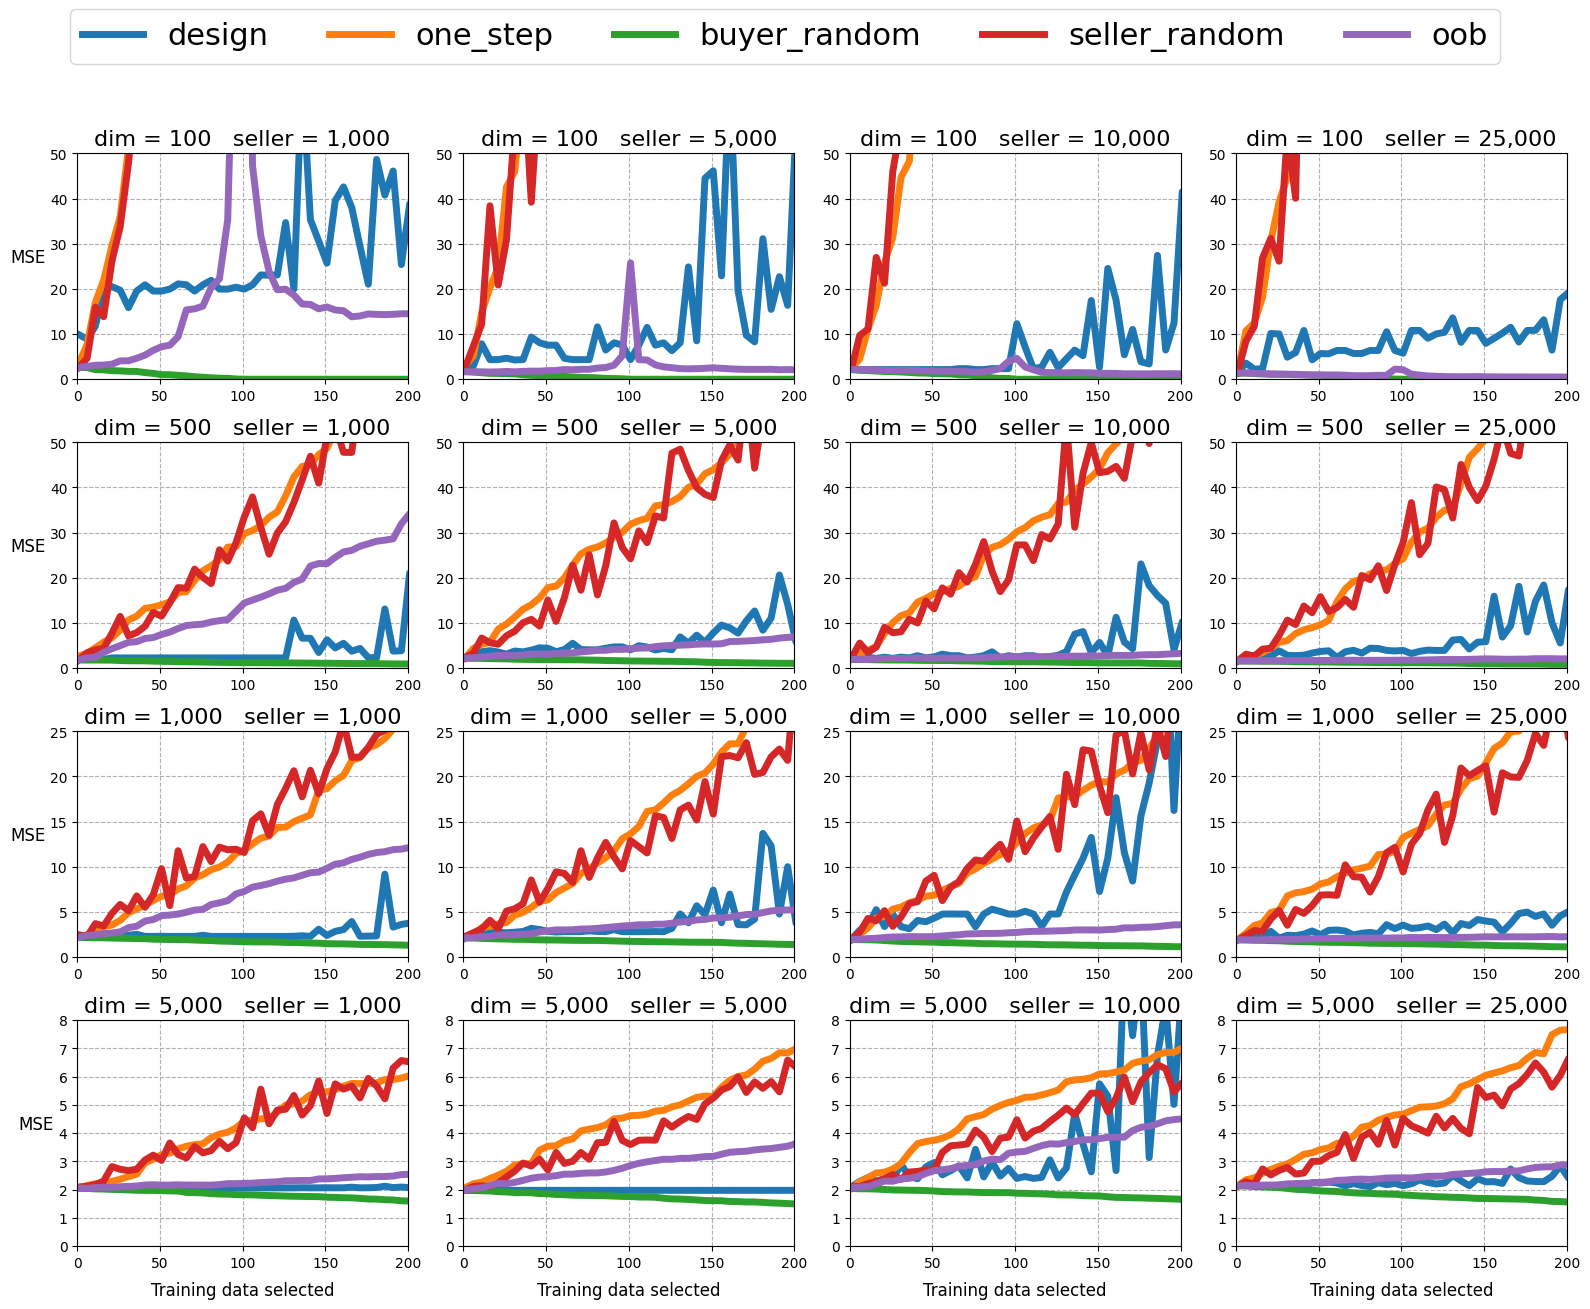

In [13]:
lw = 5
fs = 16
fig, ax = plt.subplots(ncols=len(dims), nrows=len(sellers), figsize=(4*len(sellers), 3*len(dims)), sharex=False, sharey=False)
for j, (k, v) in enumerate(seller_res.items()):
    for i, (l, u) in enumerate(v.items()):
        ax[i, j].set_title(f'dim = {l:,}   seller = {k:,}', fontsize=fs)
        ax[i, j].grid(ls='--')
        for meth, res in u.items():
            ax[i, j].plot(*zip(*res.items()), label=meth if i ==0 and j == 0 else None, lw=lw)
        ax[i, j].set_xlim(0, 200)
        if i == 0:
            ylim = 50 
        elif i == 1:
            ylim = 50
        elif i == 2:
            ylim = 25
        elif i == 3:
            ylim = 8
        ax[i, j].set_ylim(0, ylim)
        if i == len(dims) - 1:
            ax[i, j].set_xlabel('Training data selected', fontsize=fs-4, labelpad=8)
        if j == 0:
            ax[i, j].set_ylabel('MSE', fontsize=fs-4, rotation=0, labelpad=16)
fig.legend(ncol=5, fontsize=fs+6, bbox_to_anchor=(0.95, 1.1))
fig.tight_layout()
plt.savefig('gaussian-compare-dim-and-seller.eps', format='eps', bbox_inches='tight')